In [43]:
###########################################################################
#                                                                         #
#         Project 5: Social Media Data Analysis, with BlueSky             #
#                                                                         #
#                      Author : Stephen Bouchardon                        #
#                                                                         #
###########################################################################

"""

(Modules / Packages)

"""

from atproto import *
from dotenv import load_dotenv
from os import getenv
import pandas as pd
from textblob import TextBlob
import re
from collections import Counter
import matplotlib.pyplot as plt


In [44]:
###########################################################################
#                                                                         #
# Pre-loading                                                             #
# Functions : loginClient, fetchPosts                                     #
#                                                                         #
###########################################################################

"""
function loginClient:
Secure connection to personal account on Bluesky

Link documentation : https://docs.bsky.app/docs/get-started, https://docs.bsky.app/docs/starter-templates/bots

Parameters: Null
"""
def loginClient():

    load_dotenv() # load in the private credentials from .env file (email and password)

    bluesky_email = getenv("BLUESKY_EMAIL")
    bluesky_pwd = getenv("BLUESKY_PWD")

    client = Client() # login to the bluesky account via the api : atproto, in order to fetch the posts
    client.login(bluesky_email,bluesky_pwd)
    
    return client



"""
function fetchPosts:
Fetch the data by a targetted event :tag, sorting type, num. of posts (...)

Link documentation : https://docs.bsky.app/docs/api/app-bsky-feed-search-posts

Parameters:
* client : AAAAAAAAAAA
* q : search the string tag/hashtag inside the text, format: "#{value}"
* sort : ranking values, format: "latest" OR "top"
* limit : number of posts retrieved, format: integer
* since : starting date of search (inclusive), format: "{YYYY}-{MM}-{DD}T{HH}:{MM}:{SS}Z"
* until : ending date of search (non inclusive), format: "{YYYY}-{MM}-{DD}T{HH}:{MM}:{SS}Z"
* lang : language of the search, format: "{val1}{val2}"
"""
def fetchPosts(client, q="#football", sort="top",limit=100, since="2025-01-01T00:00:00Z", until="2025-06-01T00:00:00Z",lang="en"):
    # prepare a dictionnary to search the requested posts 
    search_params = {
        "q": q,  
        "sort": sort,
        "limit": limit, 
        "since" : since,
        "until" : until,
        "lang" : lang
    }

    # try to get the posts
    response = client.app.bsky.feed.search_posts(search_params)

    # get response 200 : client's request valid
    # from response, collect data in a list of dictionaries
    data = []

    for post in response.posts:
        post_record = post.record
        post_data = {
            "post_did": post.author.did,
            "post_uri": post.uri,
            "author": post.author.display_name,
            "handle": post.author.handle,
            "author_did": post.author.did,
            "text": post_record.text,
            "created_at": post_record.created_at
        }
        
        # add post values ( a dictionary ) to the list
        data.append(post_data)

    # convert list to DataFrame
    df = pd.DataFrame(data)
    return df

In [45]:
#################################################################################################
#                                                                                               #
# 1. Derive the sentiment of each post using Python modules (no need to create your Algorithm): #
# Functions : get_polarity, categorize_polarity, get_likes, get_sentimentAnalysis               #
#                                                                                               #
#################################################################################################



"""
function get_polarity:
From the library TextBlob and its sentiment analysis tools, the function calculate
the polarity score: a float within the range [-1.0, 1.0]. 
A better score is positive and tends to 1.0. If worse, to -1.0.

Link documentation : https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

Parameters:
* text : string of characters
"""
def get_polarity(text):
    return TextBlob(text).sentiment.polarity



"""
function category_polarity:

Parameters:
* p : float value representing the polarity found for a post with the function get_polarity
"""
def categorize_polarity(p):
    if p > 0:
        return 'positive'
    elif p < 0:
        return 'negative'
    else:
        return 'neutral'



"""
function get_likes:
With the uri of a post, the client retrieve the number of likes and fetch it.

Link documentation : https://docs.bsky.app/docs/api/app-bsky-feed-get-likes

Parameters:
* uri : unique identifier of the post
"""
def get_likes(client, uri):
    response = client.app.bsky.feed.get_likes({"uri": uri})
    return len(response.likes)



"""
function get_sentimentAnalysis:
Apply the functions get_polarity & get_likes to each post,
create a new dataframe with the id of the post and its sentimental scores.
Option : plot the results

Parameters:
* client :
* df_posts : DataFrame produced with the function fetchPosts
* optionPloting : 
"""

def df_sentimentAnalysis(client, df_posts, optionPlot=True):
    # initialisation of the new dataframe
    df_postAnalysis = pd.DataFrame()
    df_postAnalysis['post_uri'] = df_posts['post_uri']
    df_postAnalysis['polarity'] = df_posts['text'].apply(get_polarity)
    df_postAnalysis['category'] = df_postAnalysis['polarity'].apply(categorize_polarity) # regroup per category the polarity in the dataframe
    df_postAnalysis['likes'] = df_posts['post_uri'].apply(lambda uri: get_likes(client, uri))
    
    # sort by likes and sentiment polarity
    # the posts with the most likes and a more positive text will appear at the top of the DataFrame
    df_postAnalysisSorted = df_postAnalysis.sort_values(by=['likes', 'polarity'], ascending=False)

    # if optionPloting is true, create a copy of the ordered df because of the categorised polarties
    returnedDf = df_postAnalysisSorted

    if(optionPlot==True):
        
        plt.figure(figsize=(10, 6))
        plt.scatter(df_postAnalysisSorted['polarity'], df_postAnalysisSorted['likes'], alpha=0.7)
        plt.title('Sentiment Analysis on posts')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Number of Likes')
        plt.grid(True)
        plt.show()
        

        # count the total for each type of polarity
        sum_polarity = df_postAnalysisSorted['category'].value_counts()
        
        # get counting in desired order
        category_polarity = [
            sum_polarity.get('negative', 0),
            sum_polarity.get('neutral', 0),
            sum_polarity.get('positive', 0)
        ]

        plt.figure(figsize=(8, 6))
        plt.bar(['Negative', 'Neutral', 'Positive'], category_polarity)
        plt.title('Total Polarity per post')
        plt.ylabel('Total')
        plt.grid(axis='y')
        plt.legend()
        plt.show()

    return returnedDf

                            post_did  \
0   did:plc:byyksopccknve7ey2oztga6d   
1   did:plc:d2uirpwry3mbltn7rzuparj2   
2   did:plc:byyksopccknve7ey2oztga6d   
3   did:plc:byyksopccknve7ey2oztga6d   
4   did:plc:byyksopccknve7ey2oztga6d   
..                               ...   
86  did:plc:byyksopccknve7ey2oztga6d   
87  did:plc:qnibvnk2uui4py5gf4hp2xb4   
88  did:plc:dkn5zd75ps4azm4h3umk4hy4   
89  did:plc:4w43agypkr37xfa7n6gjzqee   
90  did:plc:i53e6y3liw2oaw4s6e6odw5m   

                                             post_uri              author  \
0   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
1   at://did:plc:d2uirpwry3mbltn7rzuparj2/app.bsky...          PythonMaps   
2   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
3   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
4   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
..                                                ...    

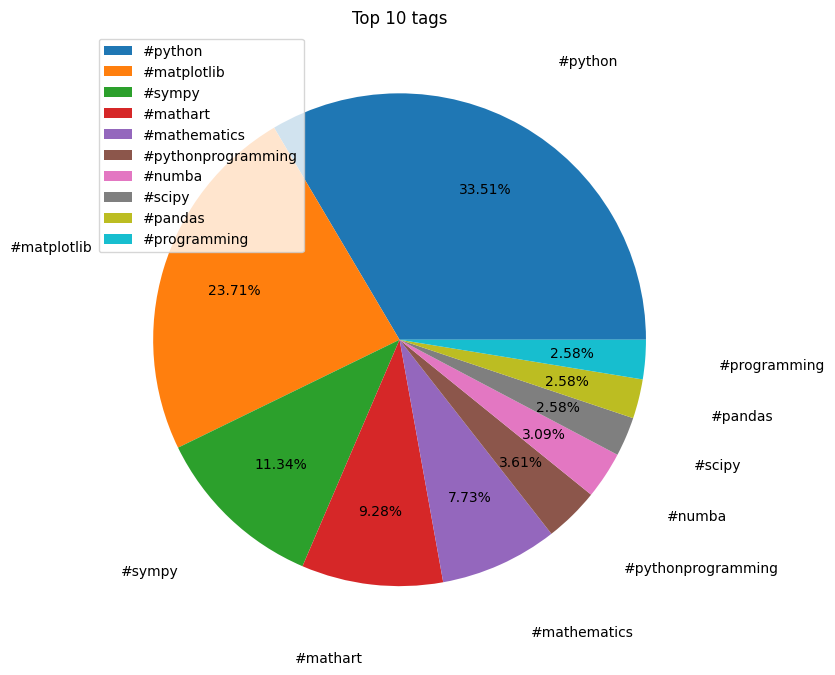

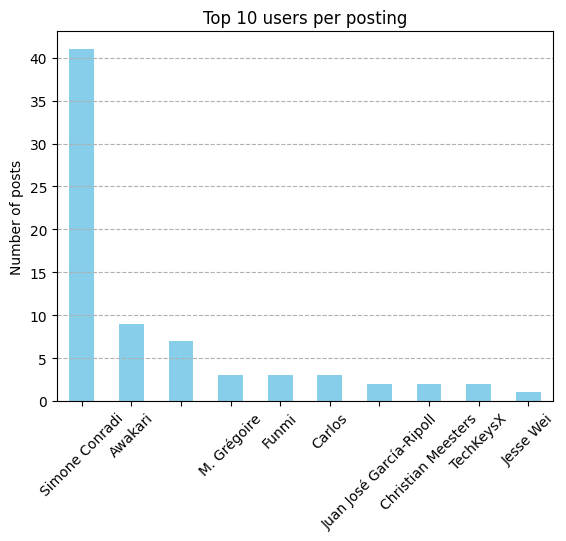

                      user  nb_posts_by_user                 tag  nb_tags
0           Simone Conradi                41             #python       65
1                  Awakari                 9         #matplotlib       46
2                                          7              #sympy       22
3              M. Grégoire                 3            #mathart       18
4                    Funmi                 3        #mathematics       15
5                   Carlos                 3  #pythonprogramming        7
6  Juan José García-Ripoll                 2              #numba        6
7       Christian Meesters                 2              #scipy        5
8                TechKeysX                 2             #pandas        5
9                Jesse Wei                 1        #programming        5
ok


In [47]:
#############################################################################
#                                                                           #
# 2. Top 10 tags and users based on their number of posts in your data set: #
# Functions : 
#############################################################################

"""
top tags based on the number of times we see them in each posts. 
Also, we remove the top one, it is the common tag used at the beginning while fetching.
"""
def get_top_tags(df_posts,n=10):
    # find the top 10 tags from the data set, except #football:
    all_tags = df_posts['text'].apply(lambda text: re.findall(r"#\w+", text.lower()))
    all_tags = [tag for sublist in all_tags for tag in sublist]
    
    # Count frequency
    tag_counts = Counter(all_tags)

    # remove the top count, it is the tag we used a as common subject for all the posts in the fetched data
    remv_tag, _ = tag_counts.most_common(1)[0]
    del tag_counts[remv_tag]

    # take only the n firsts
    top_tags = tag_counts.most_common(n)
    return top_tags


"""
same mimic as top tags.
"""
def get_top_users_most_posts(df_posts,n=10): 
    # find the top n users from the data set with the most posts
    return df_posts['author' or 'handle'].value_counts().head(n)



"""
dataframes for top users and top tags. option for plotting.
"""
def df_top_tags_users(df_posts,n=10,optionPlot=True):

    # init top tags and users
    top_tags = get_top_tags(df_posts)
    top_users = get_top_users_most_posts(df_posts)
    print(top_users)
    
    # Create two separate DataFrames
    df_top_tags = pd.DataFrame(top_tags, columns=["tag", "nb_tags"])
    
    df_top_users = top_users.reset_index()
    df_top_users.columns = ["user", "nb_posts_by_user"]
    
    # Combine into one DataFrame (for display purposes)
    top_data = pd.concat([df_top_users, df_top_tags], axis=1)

    if(optionPlot == True):

        # Tags 
        # Link : http://www.python-simple.com/python-matplotlib/pie.php
        tags, counts = zip(*top_tags)
        plt.figure(figsize = (8, 8))
        plt.pie(counts, labels = tags,
        autopct = lambda counts: str(round(counts, 2)) + '%',
        pctdistance = 0.7, labeldistance = 1.3)
        plt.title(f"Top {n} tags")
        plt.legend(loc='upper left')
        plt.show()
        
        # Users
        top_users.plot(kind='bar', color='skyblue', title=f"Top {n} users per posting")
        plt.ylabel("Number of posts")
        plt.xticks(rotation=45)
        plt.xlabel("")
        plt.grid(True, axis='y', linestyle='--')
        plt.show()
        
    return top_data

                            post_did  \
0   did:plc:byyksopccknve7ey2oztga6d   
1   did:plc:d2uirpwry3mbltn7rzuparj2   
2   did:plc:byyksopccknve7ey2oztga6d   
3   did:plc:byyksopccknve7ey2oztga6d   
4   did:plc:byyksopccknve7ey2oztga6d   
..                               ...   
86  did:plc:byyksopccknve7ey2oztga6d   
87  did:plc:qnibvnk2uui4py5gf4hp2xb4   
88  did:plc:dkn5zd75ps4azm4h3umk4hy4   
89  did:plc:4w43agypkr37xfa7n6gjzqee   
90  did:plc:i53e6y3liw2oaw4s6e6odw5m   

                                             post_uri              author  \
0   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
1   at://did:plc:d2uirpwry3mbltn7rzuparj2/app.bsky...          PythonMaps   
2   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
3   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
4   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...      Simone Conradi   
..                                                ...    

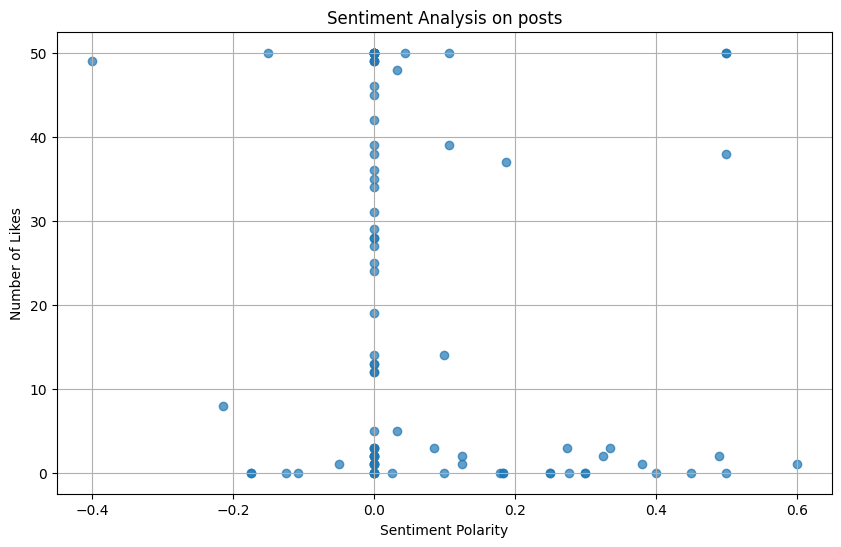

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


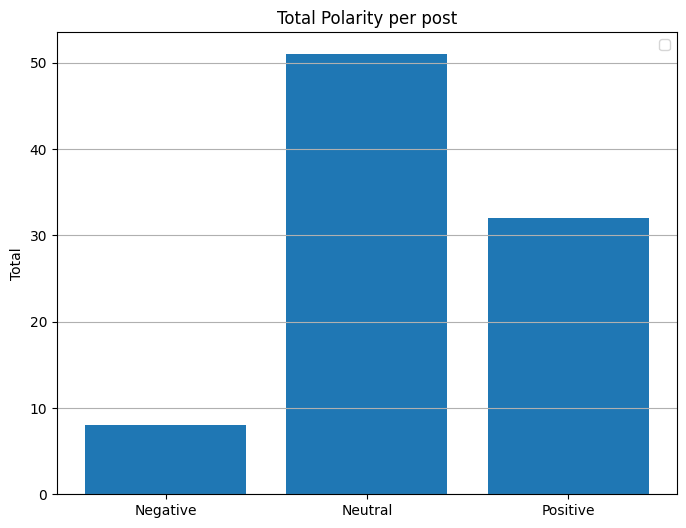

                                             post_uri  polarity  category  \
4   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...  0.500000  positive   
5   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...  0.500000  positive   
84  at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...  0.107143  positive   
8   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...  0.044444  positive   
3   at://did:plc:byyksopccknve7ey2oztga6d/app.bsky...  0.000000   neutral   
..                                                ...       ...       ...   
72  at://did:plc:7x6ucwd3fgv5rcjkxsyqdttw/app.bsky...  0.000000   neutral   
56  at://did:plc:uafzd5hp3nzouojt7o26s4st/app.bsky... -0.107143  negative   
44  at://did:plc:uzctzf6d6wkvefppurjpt76r/app.bsky... -0.125000  negative   
48  at://did:plc:i53e6y3liw2oaw4s6e6odw5m/app.bsky... -0.175000  negative   
50  at://did:plc:i53e6y3liw2oaw4s6e6odw5m/app.bsky... -0.175000  negative   

    likes  
4      50  
5      50  
84     50  
8      50  
3      50  
.. 

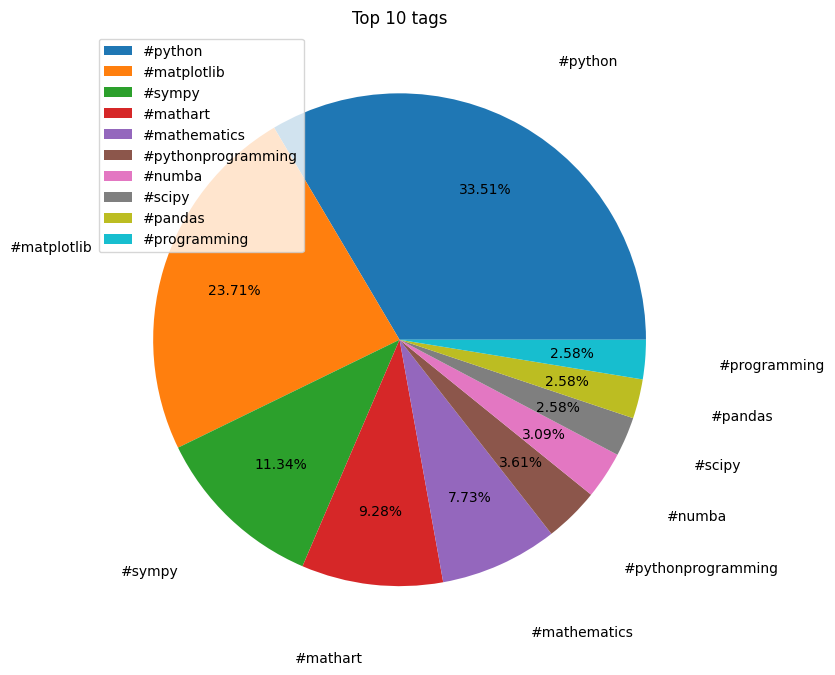

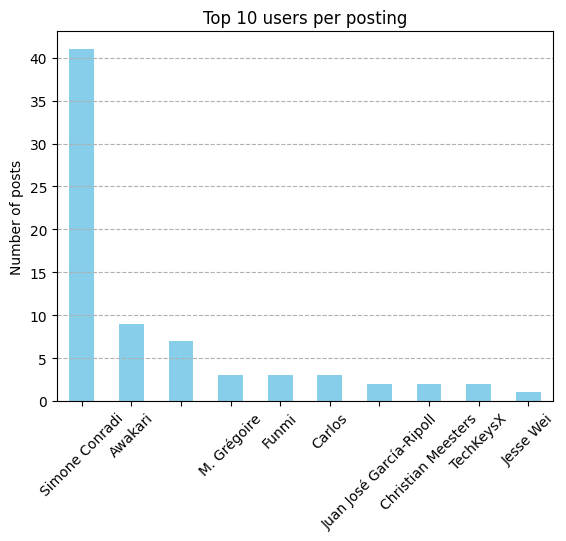

                      user  nb_posts_by_user                 tag  nb_tags
0           Simone Conradi                41             #python       65
1                  Awakari                 9         #matplotlib       46
2                                          7              #sympy       22
3              M. Grégoire                 3            #mathart       18
4                    Funmi                 3        #mathematics       15
5                   Carlos                 3  #pythonprogramming        7
6  Juan José García-Ripoll                 2              #numba        6
7       Christian Meesters                 2              #scipy        5
8                TechKeysX                 2             #pandas        5
9                Jesse Wei                 1        #programming        5
ok


NameError: name 'df_posts' is not defined

In [48]:
"""

3. Get the followers of a given social media user from your acquired data set:

"""

def main():
    client = loginClient()
    
    df_posts = fetchPosts(client, "#numpy", sort="top",limit=100, since="2025-01-01T00:00:00Z", until="2025-06-01T00:00:00Z",lang="en")
    print(df_posts)

    df_posts_senti = df_sentimentAnalysis(client,df_posts)
    print(df_posts_senti)

    df_top_tu = df_top_tags_users(df_posts)
    print(df_top_tu)
    
    print("ok")

main()

"""
function getFollowers:

With the API, the function fetch the followers data.

Link documentation : https://docs.bsky.app/docs/api/app-bsky-graph-get-followers

Parameters:
* user_did : unique identifier of the Bluesk's user
* limit : number of followers to retrieve, format: integer from [1,100]
"""
def getFollowers(user_did,limit=50):
    # Fetch followers
    response = client.app.bsky.graph.get_followers({'actor': user_did,'limit': limit})
    
    # Extract follower information
    followers = response.followers

    return followers

# find the top user did based on the first data frame where there is a column author_did. We compare the top_data DataFrame and this one:
top_user_did = df_posts[df_posts['author'] == top_data['user'].iloc[0]]['author_did'].iloc[0]
top_user_name = df_posts[df_posts['author'] == top_data['user'].iloc[0]]['author'].iloc[0] # Verify we found the top user

# Get the top user's followers:
top_user_followers = getFollowers(top_user_did,100)

# Display follower author names:
print(f"Followers of {top_user_name} :")

i=0
for i,follower in enumerate(top_user_followers):
    print(f"{i} : {follower.display_name or follower.handle}") # some users do not have displayed name. In that case, print their handle.
print(f"Total count of followers = {i+1}")


In [24]:
"""

4. Given a social media user, obtain the posts and profiles of all followers of the user and show it:

"""

# function to get profile of a user
def get_profile(user_did):
    return client.app.bsky.actor.get_profile({'actor': user_did})

# function to get recent posts of a user
def get_recent_posts(user_did, limit=5):
    response = client.app.bsky.feed.get_author_feed({'actor': user_did, 'limit': limit})
    return response.feed

# add a list to store follower information
follower_data = []

for follower in top_user_followers:
    follower_did = follower.did
    profile = get_profile(follower_did)
    posts = get_recent_posts(follower_did, limit=5)
    
    follower_info = {
        'display_name': profile.display_name,
        'handle': profile.handle,
        'avatar_url': profile.avatar,
        'description': profile.description,
        'followers_count': profile.followers_count,
        'following_count': profile.follows_count,
        'posts_count': profile.posts_count,
    }
    
    follower_data.append(follower_info)

# create a DataFrame
df_followers = pd.DataFrame(follower_data)

# display the DataFrame
print(df_followers)

       display_name                        handle  \
0        Boost Blue         boostblue.bsky.social   
1       KayPea 🤓🧐🦘🫖           kpunj15.bsky.social   
2       .A. Rayleen  handlebskysocial.bsky.social   
3     Frank Michael      frankchiller.bsky.social   
4    SaigoValentine   saigovalentine8.bsky.social   
..              ...                           ...   
74                   crackingleftfoot.bsky.social   
75  Andrés Saavedra          agsaaved.bsky.social   
76                           afcjonny.bsky.social   
77              MBJ              mbj0.bsky.social   
78       Radioheady        radioheady.bsky.social   

                                           avatar_url  \
0   https://cdn.bsky.app/img/avatar/plain/did:plc:...   
1   https://cdn.bsky.app/img/avatar/plain/did:plc:...   
2   https://cdn.bsky.app/img/avatar/plain/did:plc:...   
3   https://cdn.bsky.app/img/avatar/plain/did:plc:...   
4   https://cdn.bsky.app/img/avatar/plain/did:plc:...   
..                   

In [ ]:

# add main function here

# add an option to export in a file the data collected 

# add to all functions the parameter client in description and in option

# Sometimes a user does not have a username but only an handle: careful